# Forecasting Models
In this notebook 3 models will be developed to forecast the number of pickups over a week in Williamsburg, using external weather data. The models used are
- Simple historical average (benchmark model)
- Random Forest
- ElasticNet (penalised linear regression)

## Load data and manipulate

In [1]:
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import seaborn as sns
%matplotlib inline
# db_path = "../data/processed/shuffled.csv"
db_path = "../data/raw/2015_Green_Taxi_Trip_Data.csv"

cols = ['pickup_datetime', 'dropoff_datetime',
       'Pickup_longitude','Pickup_latitude',
        'Dropoff_longitude', 'Dropoff_latitude']

%time df = pd.read_csv(db_path,infer_datetime_format=True,usecols=cols )
# conn = sqlite3.connect(db_path)
# df = pd.read_sql("select * from taxi_data",con=conn)
#del df["index"]

CPU times: user 31.9 s, sys: 2.08 s, total: 34 s
Wall time: 35.2 s


In [2]:
df["pickup_datetime"] = pd.to_datetime(df["pickup_datetime"], format='%m/%d/%Y %I:%M:%S %p')
df["dropoff_datetime"] = pd.to_datetime(df["dropoff_datetime"], format='%m/%d/%Y %I:%M:%S %p')

## Engineer time features to capture periodicity phenomena

In [3]:
df["hour"] = df["pickup_datetime"].dt.hour
df["minute"] = df["hour"] + df["pickup_datetime"].dt.minute/60
df["weekday"] = df["pickup_datetime"].dt.dayofweek
df["half_hour"] = df["minute"].apply(lambda x : np.floor(x * 2) / 2)
df["month"] = df["pickup_datetime"].dt.month
df["day_of_year"] = df["pickup_datetime"].dt.dayofyear
df["date"] = df["pickup_datetime"].dt.date
df["day_sin"] = np.sin(df["pickup_datetime"].dt.hour*2*np.pi/24)
# df["day_cos"]
# df["year_sin"] = np.sin(df["pickup_datetime"].dt.dayofyear*2*np.pi)
# df["year_cos"]

## Sanity check

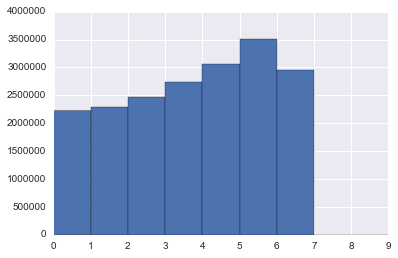

In [4]:
## Pickups by day of week

df["weekday"].hist(bins=range(0,10))

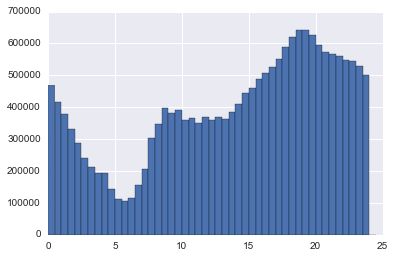

In [5]:
# Pickups by half-hour period (including weekdays and weekends)

df["half_hour"].hist(bins=np.arange(0,25,0.5))

# We will forecast for Williamsburg, one of our busiest neighbourhoods.
To do so we will need neighbourhood shapes, and then to find out if our pickup location is inside the shape
This can be a long process so we will hack a solution with geoencoding, and then transform back to regular lat/lon which will approximate the position. The advantage is this scales down the number of points to check many times (millions down to a few thousand) however we do lose some spatial resolution 

In [6]:
import json
# Load JSON shapes for neigbhourhoods
with open("../src/visualization/nyc.geojson") as f:
    nyc = json.loads(f.read())

# Find Williamsburg shape
for v in nyc["features"]:
    if v["properties"]["neighborhood"] == "Williamsburg":
        williamsburg = v

In [7]:
# Geohash Encode then decode all the dataframe points 

import geohash

df["coord"] = list(zip(df["Pickup_latitude"],df["Pickup_longitude"]))
df["coord"] = df["coord"].apply(lambda x : geohash.encode(x[0],x[1],6))
df["coord"] = df["coord"].apply(geohash.decode)

In [8]:
# Find Points in Williamsburg
from shapely.geometry import Point, shape

wburg_points = []

polygon = shape(williamsburg['geometry'])

for coords in df["coord"].unique():
    lat = coords[1]
    lon = coords[0]
    point = Point(lat,lon) 
    if polygon.contains(point):
        wburg_points +=[str(coords)]

    
print(wburg_points)

# # count = df["coord"].value_counts()
# busiest_location = count.index.values[0]
# busiest = df.loc[df["coord"] == busiest_location]
# print(busiest_location)

['(40.71807861328125, -73.9544677734375)', '(40.71258544921875, -73.9654541015625)', '(40.71258544921875, -73.9544677734375)', '(40.71807861328125, -73.9654541015625)', '(40.70709228515625, -73.9434814453125)', '(40.70159912109375, -73.9544677734375)', '(40.70709228515625, -73.9654541015625)', '(40.71258544921875, -73.9434814453125)', '(40.70709228515625, -73.9544677734375)', '(40.70709228515625, -73.9324951171875)', '(40.70159912109375, -73.9434814453125)', '(40.71807861328125, -73.9434814453125)', '(40.71258544921875, -73.9324951171875)']


In [30]:
# temp = df.head(10000)
df["coord"] = df["coord"].astype(str)

busiest = df.loc[df["coord"].isin(wburg_points) == True]

# Let's do some exploration

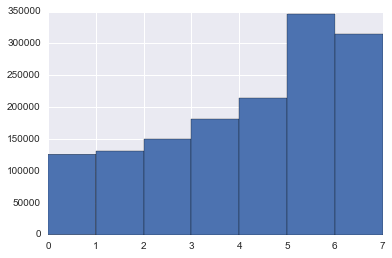

In [31]:
busiest["pickup_datetime"].dt.dayofweek.hist(bins=range(0,8))

# busiest["pickup_datetime"].dt.dayofweek.value_counts()

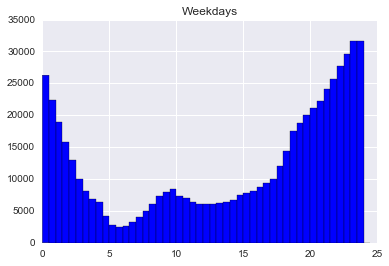

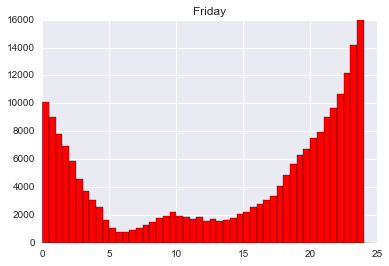

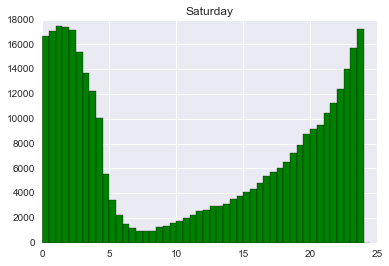

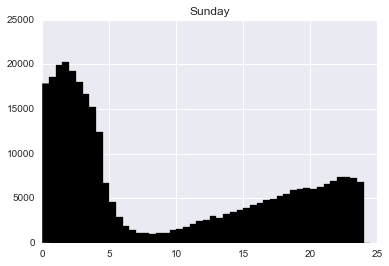

In [32]:
weekdays = busiest.loc[busiest["pickup_datetime"].dt.dayofweek < 4]
friday = busiest.loc[busiest["pickup_datetime"].dt.dayofweek == 4]
saturday = busiest.loc[busiest["pickup_datetime"].dt.dayofweek == 5]
sunday = busiest.loc[busiest["pickup_datetime"].dt.dayofweek == 6]

plt.title("Weekdays")
weekdays["half_hour"].hist(bins=np.arange(0,25,0.5),color="b")
plt.show()
plt.title("Friday")
friday["half_hour"].hist(bins=np.arange(0,25,0.5),color="r")
plt.show()
plt.title("Saturday")
saturday["half_hour"].hist(bins=np.arange(0,25,0.5),color="g")
plt.show()
plt.title("Sunday")
sunday["half_hour"].hist(bins=np.arange(0,25,0.5),color="k")

plt.show()

In [33]:
busiest.index = busiest["pickup_datetime"]
busiest = busiest.resample("H").agg("count")
busiest = busiest["pickup_datetime"]

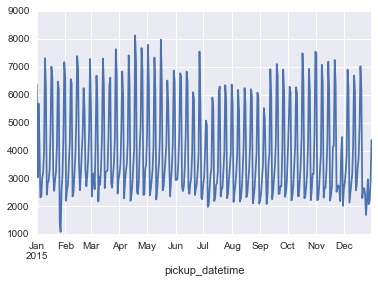

In [36]:
# weekday["month"].hist(bins=range(1,14))
busiest.resample("D").agg("sum").plot()

In [15]:
#pd.rolling_mean(busiest.groupby(["day_of_year"]).agg("count")["hour"],14).plot() #.hist(bins=range(0,367))
# busiest.groupby(["date"]).agg("count")["hour"].plot() #.hist(bins=range(0,367))
# daily = busiest.groupby(["date"]).agg("count")["hour"]

In [16]:
# daily.index = pd.to_datetime(daily.index)
# daily = daily.rename(cols={"hour":"count"})

# get weather data

In [37]:
weather_path = "../data/external/weather_2015.csv"

weather_cols = ["date","hour","temp",
                "precip",
                "rain","snow",]
weather = pd.read_csv(weather_path,usecols=weather_cols)
# print(weather)
weather["date"] = weather["date"].astype(str) + " " + weather["hour"].astype(str) + ":00"

weather["date"] = pd.to_datetime(weather["date"],format="%Y-%m-%d %H:%M")
# weather["DATE"] = weather["DATE"].dt.date

# Remove 2016 date in a safe way
weather = weather.loc[weather["date"].dt.year == 2015]

weather.index = weather["date"]
del weather["date"]
weather = weather.resample("H").agg("mean")
weather = weather.fillna(method="bfill")
# print(weather[pd.isnull(weather).any(axis=1)])

In [38]:
weather["precip"] = weather["precip"].apply(lambda x : 0 if x<0 else x)

In [39]:
# busiest
X=pd.concat([weather,busiest],axis=1)
X = X.rename(columns={"pickup_datetime" : "pickups"})
X["dow"] = X.index.dayofweek
X["month"] = X.index.month
X["year_sin"] = np.sin(X.index.dayofyear*2*np.pi/365)
# X["year_cos"] = np.cos(X.index.dayofyear*2*np.pi/365)
X["day_sin"] = np.sin(X.index.hour*2*np.pi/24)
# X["day_cos"] = np.cos(X.index.hour*2*np.pi/24)

In [40]:
# weekday = X.loc[X.hour == 8]
# weekday = weekday.loc[weekday.loc]
# # print(weekday)
# plt.plot(weekday["precip"],weekday["pickups"],'o')
# X["year_sin"].plot()
# np.cos(X.index.dayofyear*np.pi/365)

In [134]:
# RF
import datetime
cutoff_dt = datetime.datetime.strptime('2015-10-16 00:00:00', '%Y-%m-%d %H:%M:%S')
cutoff_dt_plus_one = datetime.datetime.strptime('2015-10-16 01:00:00', '%Y-%m-%d %H:%M:%S')
end_dt = datetime.datetime.strptime('2015-10-22 00:00:00', '%Y-%m-%d %H:%M:%S')

temp = X.ix[:cutoff_dt]

## Create "average hour/day column from training data, then add this to test too"
dic = (X.groupby(["dow","hour"]).agg("mean")["pickups"].unstack().T).to_dict()

X["expected"] = X.apply(lambda row: int(dic[row["dow"]][row["hour"]]),axis=1)
X["last_week"] = X["pickups"].shift(24*7)
# Drop nans from first week of year
X = X.dropna()

train = X.ix[:cutoff_dt]
test = X.ix[cutoff_dt_plus_one:end_dt]

Y_train = np.array(train["pickups"])
del train["pickups"]
X_train = np.array(train)

Y_test = np.array(test["pickups"])
del test["pickups"]
X_test = np.array(test)

/home/james/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:17: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix


# Effect of Rainfall

15352.2002266
27681.0845388


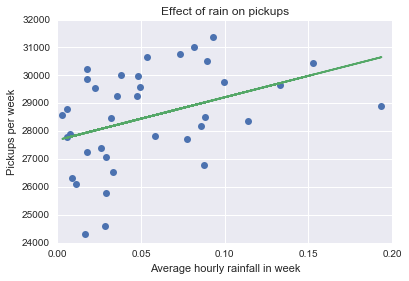

In [113]:
from scipy import stats


temp=pd.concat([weather,busiest],axis=1)
temp = temp.rename(columns={"pickup_datetime" : "pickups"})
temp = temp.resample("W").agg(["mean","sum"])

# temp = temp.loc[temp.index.dayofweek >]
temp = temp.loc[temp["rain"]["mean"]>0]
# print(temp["pickups"])
temp = temp.loc[temp["pickups"]["sum"]>22000]
temp = pd.concat([temp["rain"]["mean"],temp["pickups"]["sum"]],axis=1)
plt.plot(temp["mean"],temp["sum"],'o')

x_arr = temp["mean"].values
y_arr = temp["sum"].values
slope, intercept, r_value, p_value, std_err = stats.linregress(x_arr,y_arr)
plt.xlabel("Average hourly rainfall in week")
plt.ylabel("Pickups per week")
plt.title("Effect of rain on pickups")
plt.plot(x_arr,x_arr*slope + intercept)
print(slope)
print(intercept)

In [ ]:
# Effect of Temperature

-84.3624984356
29658.3296148


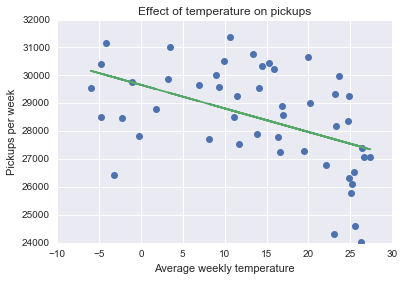

In [115]:

temp=pd.concat([weather,busiest],axis=1)
temp = temp.rename(columns={"pickup_datetime" : "pickups"})
temp = temp.resample("W").agg(["mean","sum"])

# print(temp["pickups"])
temp = temp.loc[temp["pickups"]["sum"]>22000]
temp = pd.concat([temp["temp"]["mean"],temp["pickups"]["sum"]],axis=1)
plt.plot(temp["mean"],temp["sum"],'o')

x_arr = temp["mean"].values
y_arr = temp["sum"].values
slope, intercept, r_value, p_value, std_err = stats.linregress(x_arr,y_arr)
plt.xlabel("Average weekly temperature")
plt.ylabel("Pickups per week")
plt.title("Effect of temperature on pickups")
plt.plot(x_arr,x_arr*slope + intercept)
print(slope)
print(intercept)

# Benchmark model

In [116]:
benchmark = X.ix[:cutoff_dt].groupby(["dow","hour"]).agg("mean")["pickups"].unstack().T
benchmark = benchmark.to_dict()
# benchmark.plot()
# test

# print(benchmark)
# stop

benchmark_pred = []

for row in test.iterrows():
#     print(row[1]["hour"],row[1]["dow"])
    
    benchmark_pred += [int(benchmark[row[1]["dow"]][row[1]["hour"]])]
    
benchmark_pred = np.array(benchmark_pred)

0.964998672032
30.6508111185


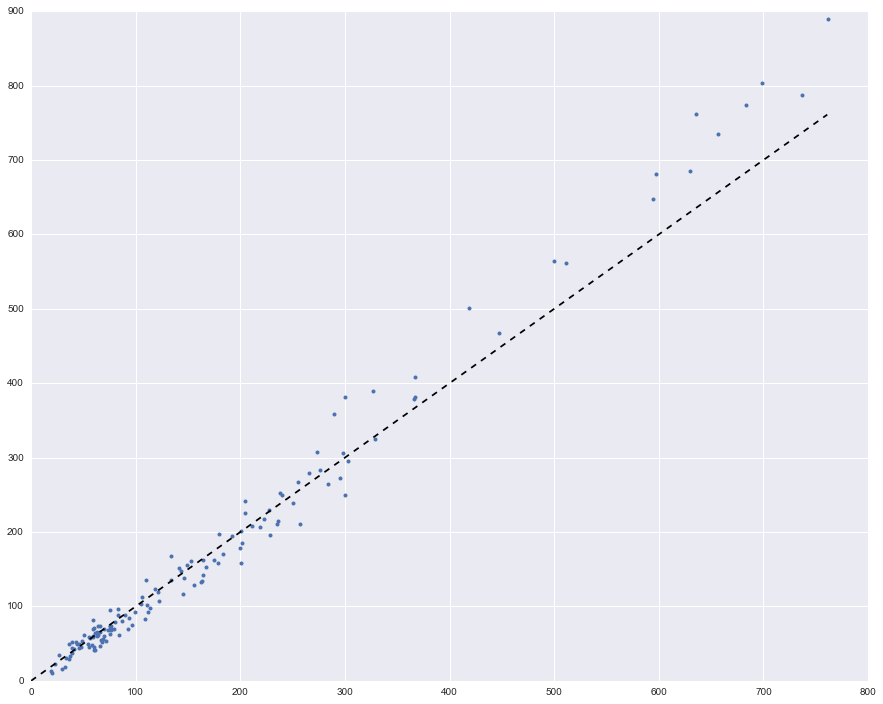

/home/james/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:11: FutureWarning: pd.rolling_mean is deprecated for ndarrays and will be removed in a future version
/home/james/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:14: FutureWarning: pd.rolling_mean is deprecated for ndarrays and will be removed in a future version


(0, 180)

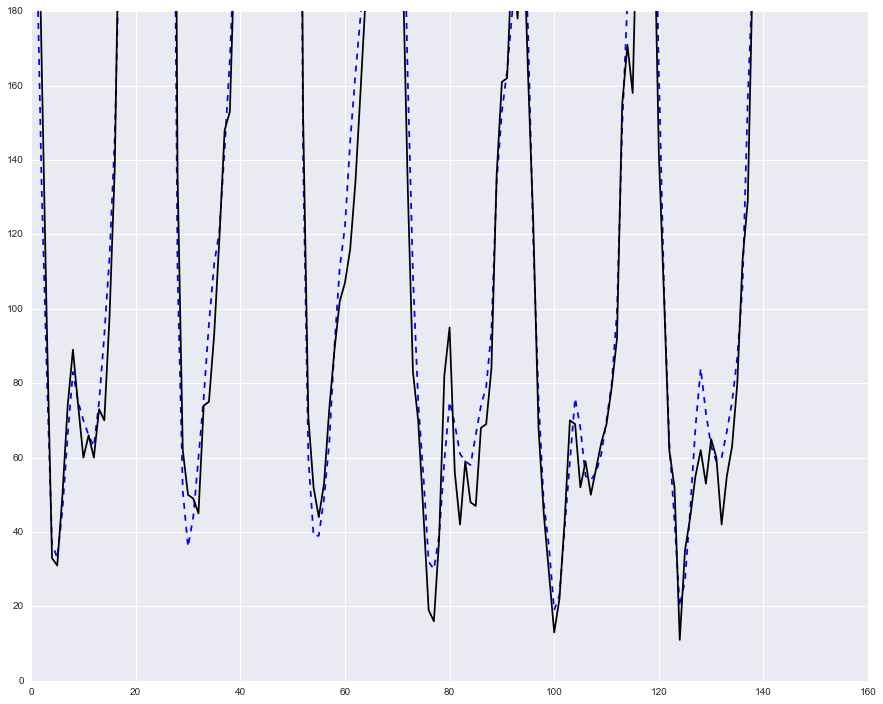

In [159]:
from sklearn.metrics import r2_score

print(r2_score(benchmark_pred,Y_test))
print(np.sqrt(mean_squared_error(benchmark_pred,Y_test)))

plt.figure(figsize=(15,12))
plt.plot(benchmark_pred,Y_test,"o",markersize=4)
plt.plot(range(0,int(max(benchmark_pred))),range(0,int(max(benchmark_pred))),'k--')
plt.show()
plt.figure(figsize=(15,12))
plt.plot(pd.rolling_mean(benchmark_pred,1),'b--')

# plt.plot(pd.rolling_mean(Y_pred_rf_ln,1),'r--')
plt.plot(pd.rolling_mean(Y_test,1),'k')
plt.ylim([0,180])

# Random Forest

In [146]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.grid_search import GridSearchCV

### RANDOM FOREST
# params = {"n_jobs": -1,
#          "n_estimators": 5000,
#          "max_features": "auto",
#           "min_samples_leaf": 3,
#           "oob_score": True,
#           "random_state" : 42
#          }

# rf_model = RandomForestRegressor(**params)

# Using CV
params = {"n_jobs":[-1],
         "n_estimators":[5000],
         "max_features":["auto"],
#          "min_samples_leaf": [3,7,11],
         "max_depth" : [3,7,11],
          "oob_score":[True],
          "random_state" : [42]
         }
rf = RandomForestRegressor(**params)
rf_model = GridSearchCV(rf,params,cv=3,scoring='neg_mean_squared_error')
rf_model.fit(X_train, (Y_train))
#Y_pred_rf = np.rint(np.expm1(rf_model.predict(X_test)))
Y_pred_rf = np.rint((rf_model.predict(X_test)))
print("==== RANDOM FOREST ====")
print(rf_model.best_params_)
print(rf_model.grid_scores_)
print(rf_model.score(X_train, Y_train))

==== RANDOM FOREST ====
{'oob_score': True, 'random_state': 42, 'n_jobs': -1, 'n_estimators': 5000, 'max_depth': 7, 'max_features': 'auto'}
[mean: -1573.90815, std: 273.39290, params: {'oob_score': True, 'random_state': 42, 'n_jobs': -1, 'n_estimators': 5000, 'max_depth': 3, 'max_features': 'auto'}, mean: -1364.41355, std: 351.99894, params: {'oob_score': True, 'random_state': 42, 'n_jobs': -1, 'n_estimators': 5000, 'max_depth': 7, 'max_features': 'auto'}, mean: -1394.83882, std: 395.32810, params: {'oob_score': True, 'random_state': 42, 'n_jobs': -1, 'n_estimators': 5000, 'max_depth': 11, 'max_features': 'auto'}]


/home/james/anaconda3/lib/python3.5/site-packages/sklearn/grid_search.py:438: ChangedBehaviorWarning: The long-standing behavior to use the estimator's score function in GridSearchCV.score has changed. The scoring parameter is now used.
  ChangedBehaviorWarning)


-772.843428464


0.967300858129
29.8826408174


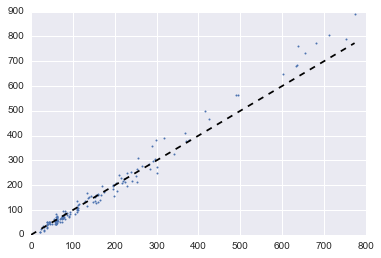

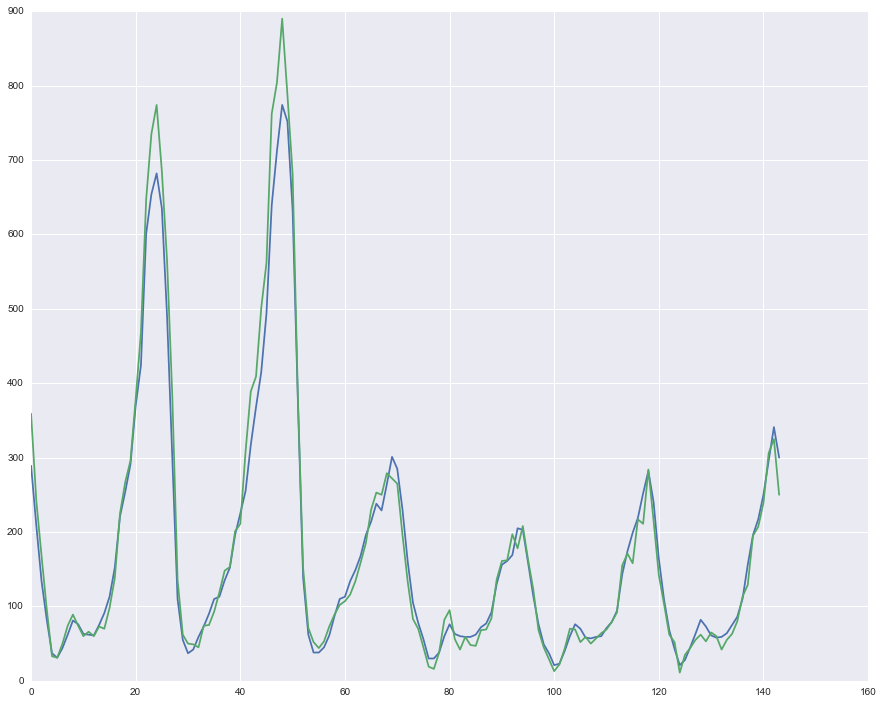

In [156]:
from sklearn.metrics import r2_score

print(r2_score(Y_pred_rf,Y_test))

print(np.sqrt(mean_squared_error(Y_pred_rf, Y_test)))


plt.plot(Y_pred_rf,Y_test,"o",markersize=2)
plt.plot(range(0,int(max(Y_pred_rf))),range(0,int(max(Y_pred_rf))),'k--')
plt.show()
plt.figure(figsize=(15,12))
plt.plot(Y_pred_rf)
plt.plot(Y_test)

Feature ranking:
1. feature temp (0.963593)
2. feature rain (0.022247)
3. feature snow (0.003866)
4. feature precip (0.003442)
5. feature year_sin (0.001751)
6. feature day_sin (0.000957)
7. feature expected (0.000695)
8. feature last_week (0.000609)
9. feature hour_0.0 (0.000560)
10. feature hour_1.0 (0.000326)
11. feature hour_2.0 (0.000243)
12. feature hour_3.0 (0.000155)
13. feature hour_4.0 (0.000141)
14. feature hour_5.0 (0.000133)
15. feature hour_6.0 (0.000124)
16. feature hour_7.0 (0.000122)
17. feature hour_8.0 (0.000101)
18. feature hour_9.0 (0.000098)
19. feature hour_10.0 (0.000096)
20. feature hour_11.0 (0.000096)
21. feature hour_12.0 (0.000086)
22. feature hour_13.0 (0.000080)
23. feature hour_14.0 (0.000067)
24. feature hour_15.0 (0.000063)
25. feature hour_16.0 (0.000054)
26. feature hour_17.0 (0.000052)
27. feature hour_18.0 (0.000049)
28. feature hour_19.0 (0.000031)
29. feature hour_20.0 (0.000027)
30. feature hour_21.0 (0.000026)
31. feature hour_22.0 (0.000022)
3

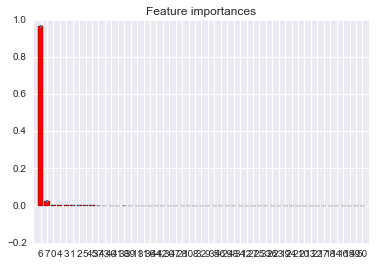

In [148]:
# test["precip"].plot()
feature_names = test.columns.values

best_model = rf_model.best_estimator_
importances = best_model.feature_importances_
std = np.std([tree.feature_importances_ for tree in best_model.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f,name in zip(range(X_train.shape[1]),feature_names):
    print("%d. feature %s (%f)" % (f + 1, feature_names[f], importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(X_train.shape[1]), importances[indices],
       color="r", yerr=std[indices],
        align="center")
plt.xticks(range(X_train.shape[1]), indices)
plt.xlim([-1, X_train.shape[1]])
plt.show()

# RF with Log

In [139]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.grid_search import GridSearchCV

### RANDOM FOREST
# params = {"n_jobs": -1,
#          "n_estimators": 5000,
#          "max_features": "auto",
#           "min_samples_leaf": 3,
#           "oob_score": True,
#           "random_state" : 42
#          }

# rf_model = RandomForestRegressor(**params)

# Using CV
params = {"n_jobs":[-1],
         "n_estimators":[250],
         "max_features":["auto"],
#           "min_samples_leaf": [3,5],
          "max_depth" : [3,5,7,9],
          "oob_score":[True],
          "random_state" : [42]
         }

rf = RandomForestRegressor(**params)
rf_model = GridSearchCV(rf,params,cv=3,scoring='neg_mean_squared_error')
rf_model.fit(X_train, np.log1p(Y_train))
#Y_pred_rf = np.rint(np.expm1(rf_model.predict(X_test)))
Y_pred_rf_ln = np.rint(np.expm1(rf_model.predict(X_test)))
print("==== RANDOM FOREST ====")
print(rf_model.best_params_)
print(rf_model.grid_scores_)
print(rf_model.score(X_train, Y_train))

KeyboardInterrupt: 

In [ ]:
from sklearn.metrics import r2_score

print(r2_score(Y_pred_rf_ln,Y_test))


plt.figure(figsize=(15,12))
plt.plot(Y_pred_rf_ln,Y_test,"o",markersize=4)
plt.plot(range(0,int(max(Y_pred_rf_ln))),range(0,int(max(Y_pred_rf_ln))),'k--')
plt.show()
plt.figure(figsize=(15,12))
plt.plot(pd.rolling_mean(Y_pred_rf_ln,1),'r--')
plt.plot(pd.rolling_mean(Y_test,1),'k')
plt.ylim([0,180])

In [ ]:
# test["precip"].plot()
feature_names = test.columns.values

best_model = rf_model.best_estimator_
importances = best_model.feature_importances_
std = np.std([tree.feature_importances_ for tree in best_model.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f,name in zip(range(X_train.shape[1]),feature_names):
    print("%d. feature %s (%f)" % (f + 1, feature_names[f], importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(X_train.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(X_train.shape[1]), indices)
plt.xlim([-1, X_train.shape[1]])
plt.show()

# ElasticNet

## One-hot encoding for hour/month/dow

In [140]:
# Reload data

X_enet =pd.concat([weather,busiest],axis=1)
X_enet = X_enet.rename(columns={"pickup_datetime" : "pickups"})
X_enet["dow"] = X_enet.index.dayofweek
X_enet["month"] = X_enet.index.month
X_enet["year_sin"] = np.sin(X_enet.index.dayofyear*2*np.pi/365)
# X["year_cos"] = np.cos(X.index.dayofyear*2*np.pi/365)
X_enet["day_sin"] = np.sin(X_enet.index.hour*2*np.pi/24)



import datetime
cutoff_dt = datetime.datetime.strptime('2015-10-16 00:00:00', '%Y-%m-%d %H:%M:%S')
cutoff_dt_plus_one = datetime.datetime.strptime('2015-10-16 01:00:00', '%Y-%m-%d %H:%M:%S')
end_dt = datetime.datetime.strptime('2015-10-22 00:00:00', '%Y-%m-%d %H:%M:%S')

temp = X_enet.ix[:cutoff_dt]

## Create "average hour/day column from training data, then add this to test too"
dic = (X_enet.groupby(["dow","hour"]).agg("mean")["pickups"].unstack().T).to_dict()


X_enet["expected"] = X_enet.apply(lambda row: int(dic[row["dow"]][row["hour"]]),axis=1)
X_enet["last_week"] = X_enet["pickups"].shift(24*7)
# Drop nans from first week of year
X_enet = X_enet.dropna()


ohe_cols = ["hour","dow","month"]
for colname in ohe_cols:
    X_enet = pd.concat([X_enet,pd.get_dummies(X_enet[colname],prefix=colname)],axis=1)
    del X_enet[colname]

train = X_enet.ix[:cutoff_dt]
test = X_enet.ix[cutoff_dt_plus_one:end_dt]

Y_train = np.array(train["pickups"])
del train["pickups"]
X_train = np.array(train)

Y_test = np.array(test["pickups"])
del test["pickups"]
X_test = np.array(test)
# print(X_enet["hour"])

/home/james/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:18: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix
/home/james/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:35: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix


In [141]:
X_enet.columns.values

array(['temp', 'rain', 'snow', 'precip', 'pickups', 'year_sin', 'day_sin',
       'expected', 'last_week', 'hour_0.0', 'hour_1.0', 'hour_2.0',
       'hour_3.0', 'hour_4.0', 'hour_5.0', 'hour_6.0', 'hour_7.0',
       'hour_8.0', 'hour_9.0', 'hour_10.0', 'hour_11.0', 'hour_12.0',
       'hour_13.0', 'hour_14.0', 'hour_15.0', 'hour_16.0', 'hour_17.0',
       'hour_18.0', 'hour_19.0', 'hour_20.0', 'hour_21.0', 'hour_22.0',
       'hour_23.0', 'dow_0', 'dow_1', 'dow_2', 'dow_3', 'dow_4', 'dow_5',
       'dow_6', 'month_1', 'month_2', 'month_3', 'month_4', 'month_5',
       'month_6', 'month_7', 'month_8', 'month_9', 'month_10', 'month_11',
       'month_12'], dtype=object)

In [166]:
from sklearn.linear_model import ElasticNet 


params = {
     "alpha":[10**x for x in np.arange(-1,-0.5,0.05)],
     "l1_ratio" : np.arange(0.75,1.01,0.05)
     }


enet = ElasticNet(**params)
enet_model = GridSearchCV(enet,params,cv=5,scoring='neg_mean_squared_error')
enet_model.fit(X_train, (Y_train))
Y_pred = enet_model.predict(X_test)

In [167]:
print(enet_model.best_params_)
# print([10**x for x in np.arange(-15,-5,0.25)])

{'l1_ratio': 1.0000000000000002, 'alpha': 0.22387211385683412}


0.965711304555
30.4236351992
temp -0.374749664191
rain 15.0561604241
snow -14.4287458145
precip 0.14651526001
year_sin 2.79801173055
day_sin -1.06011079671
expected 0.832643922625
last_week 0.173849167488
hour_0.0 0.0
hour_1.0 -0.0
hour_2.0 -0.0
hour_3.0 -0.0
hour_4.0 -0.0
hour_5.0 -0.0
hour_6.0 -0.0
hour_7.0 -0.0
hour_8.0 0.0
hour_9.0 0.0
hour_10.0 0.0
hour_11.0 0.0
hour_12.0 0.0
hour_13.0 0.0
hour_14.0 0.0
hour_15.0 0.0
hour_16.0 -0.0
hour_17.0 0.0
hour_18.0 -0.0
hour_19.0 -0.0
hour_20.0 -0.0
hour_21.0 -0.0
hour_22.0 0.0
hour_23.0 0.0
dow_0 0.0
dow_1 -0.0
dow_2 -0.0
dow_3 -2.42904784172
dow_4 0.0
dow_5 0.0
dow_6 0.0
month_1 -4.48719118157
month_2 0.0
month_3 -0.0
month_4 2.52065895394
month_5 4.44816052994
month_6 0.0
month_7 -6.68038074002
month_8 -1.46469105734
month_9 0.0
month_10 0.0
month_11 0.0
month_12 0.0


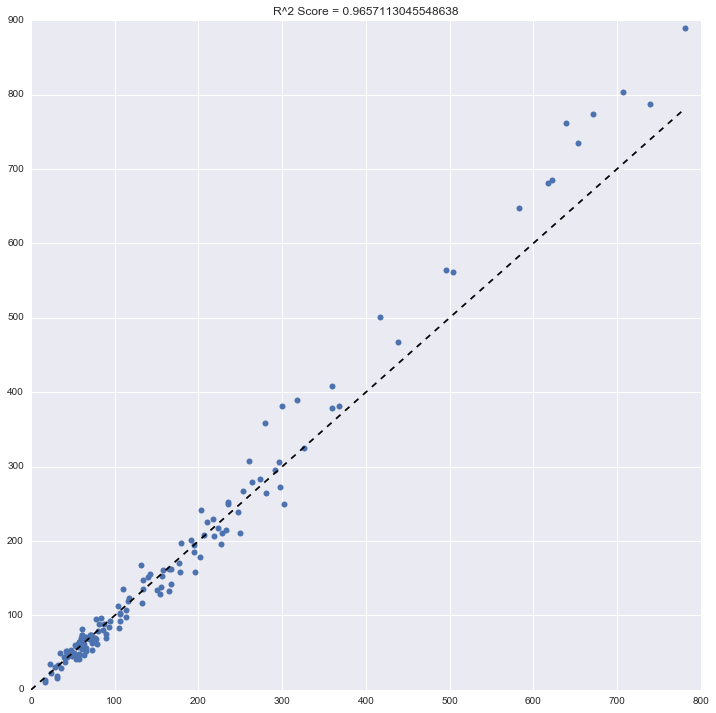

/home/james/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:19: FutureWarning: pd.rolling_mean is deprecated for ndarrays and will be removed in a future version
/home/james/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:21: FutureWarning: pd.rolling_mean is deprecated for ndarrays and will be removed in a future version


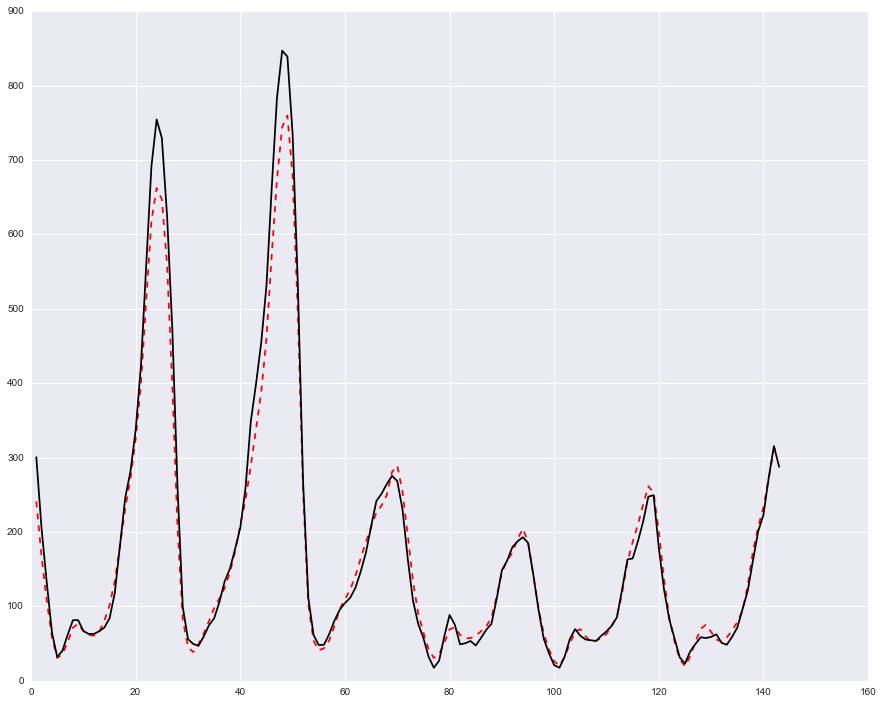

In [168]:
from sklearn.metrics import r2_score

print(r2_score(Y_pred,Y_test))
# print(enet_model.best_estimator_.coef_)

print(np.sqrt(mean_squared_error(Y_pred, Y_test)))

feature_names = test.columns.values

for feat,val in zip(feature_names,enet_model.best_estimator_.coef_):
    print(feat, val)

plt.figure(figsize=(12,12))
plt.title("R^2 Score = {}".format(r2_score(Y_pred,Y_test)))
plt.plot(Y_pred,Y_test,"o",markersize=6)
plt.plot(range(0,int(max(Y_pred))),range(0,int(max(Y_pred))),'k--')
plt.show()
plt.figure(figsize=(15,12))
plt.plot(pd.rolling_mean(Y_pred,2),'r--')
# plt.plot(pd.rolling_mean(benchmark_pred,2),'b--')
plt.plot(pd.rolling_mean(Y_test,2),'k')
# plt.ylim([0,180])

# Ensembling

0.966406994137
30.1377709663


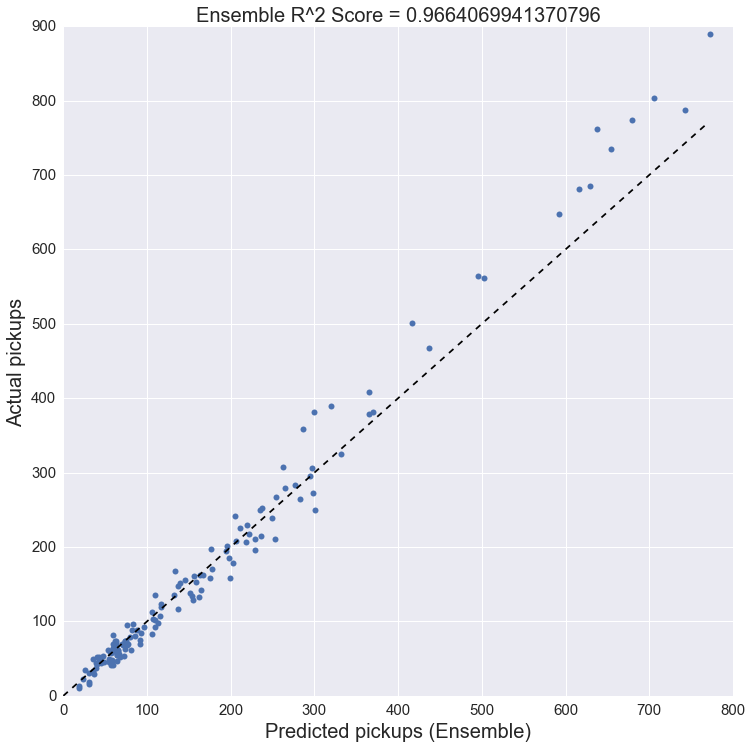

/home/james/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:23: FutureWarning: pd.rolling_mean is deprecated for ndarrays and will be removed in a future version
/home/james/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:25: FutureWarning: pd.rolling_mean is deprecated for ndarrays and will be removed in a future version


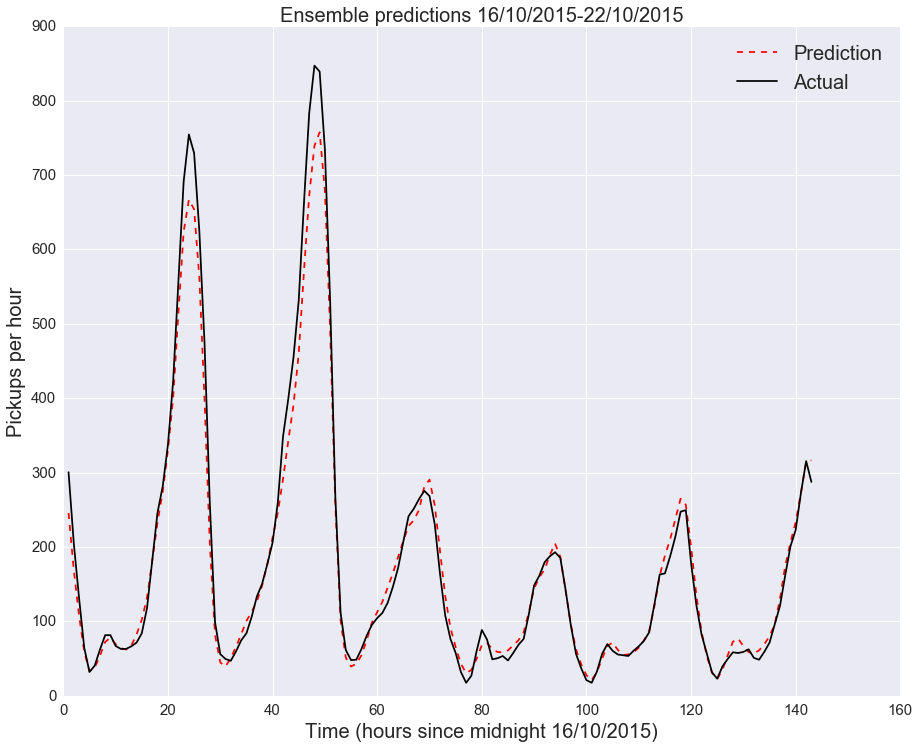

In [183]:
from sklearn.metrics import r2_score, mean_squared_error
Y_ensemble = (Y_pred+Y_pred_rf+benchmark_pred)/3
print(r2_score(Y_ensemble,Y_test))
# print(enet_model.best_estimator_.coef_)
print(np.sqrt(mean_squared_error(Y_ensemble, Y_test)))
plt.figure(figsize=(12,12))
plt.title("Ensemble R^2 Score = {}".format(r2_score(Y_ensemble,Y_test)),fontsize=20)

plt.ylabel("Actual pickups",fontsize=20)
plt.yticks(fontsize=15)
plt.xlabel("Predicted pickups (Ensemble)",fontsize=20)
plt.xticks(fontsize=15)

plt.plot(Y_ensemble,Y_test,"o",markersize=6)
plt.plot(range(0,int(max(Y_ensemble))),range(0,int(max(Y_ensemble))),'k--')
plt.show()
plt.figure(figsize=(15,12))
plt.title("Ensemble predictions 16/10/2015-22/10/2015",fontsize=20)
plt.ylabel("Pickups per hour",fontsize=20)
plt.yticks(fontsize=15)
plt.xlabel("Time (hours since midnight 16/10/2015)",fontsize=20)
plt.xticks(fontsize=15)
plt.plot(pd.rolling_mean(Y_ensemble,2),'r--',label="Prediction")
# plt.plot(pd.rolling_mean(benchmark_pred,2),'b--')
plt.plot(pd.rolling_mean(Y_test,2),'k',label="Actual")
plt.legend(prop={'size':20})

# SARIMAX - see other notebook


In [ ]:
# import statsmodels.tsa.api as smt

# def plots(data, lags=None):
#     plt.figure(figsize=(14,12))

#     layout = (1, 3)
#     raw  = plt.subplot2grid(layout, (0, 0))
#     acf  = plt.subplot2grid(layout, (0, 1))
#     pacf = plt.subplot2grid(layout, (0, 2))
    
#     data.plot(ax=raw)
#     smt.graphics.plot_acf(data, lags=lags, ax=acf)
#     smt.graphics.plot_pacf(data, lags=lags, ax=pacf)
#     sns.despine()
#     plt.tight_layout()

In [ ]:
import statsmodels.api as sm

X_arima =pd.concat([weather,busiest],axis=1)
X_arima.to_csv("../data/processed/X_arima.csv")

# X_arima = X_arima.rename(columns={"pickup_datetime" : "pickups"})
# # fit SARIMA monthly based on helper plots
# exog = np.array(X_arima[["hour","temp","precip"]])
# Y_arima = np.array(X_arima["pickups"])

# sar = sm.tsa.statespace.SARIMAX(Y_arima, exog=exog ,order=(1,0,0), seasonal_order=(0,1,1,24), trend='c').fit()
# sar.summary()


In [ ]:
plt.plot(sar.predict())